In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
precip = xr.open_dataset("precip_1901_2020.nc")
precip

C:\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.Dataset>
Dimensions:    (LONGITUDE: 35, LATITUDE: 33, TIME: 43830)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 ... 97.5 98.5 99.5 100.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5 ... 35.5 36.5 37.5 38.5
  * TIME       (TIME) datetime64[ns] 1901-01-01 1901-01-02 ... 2020-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6

In [3]:
precip_1951 =precip.sel(TIME=slice('1901-01-01','2020-12-31'))

In [4]:
months = [6,7,8,9]
MAM_precip= precip_1951.sel(TIME=np.in1d(precip_1951['TIME.month'], months));
MAM_precip

<xarray.Dataset>
Dimensions:    (LONGITUDE: 35, LATITUDE: 33, TIME: 14640)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 ... 97.5 98.5 99.5 100.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5 ... 35.5 36.5 37.5 38.5
  * TIME       (TIME) datetime64[ns] 1901-06-01 1901-06-02 ... 2020-09-30
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6

In [65]:

precip_y=MAM_precip.groupby('TIME.year').mean('TIME')
precip_y

<xarray.Dataset>
Dimensions:    (LONGITUDE: 35, LATITUDE: 33, year: 120)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 ... 97.5 98.5 99.5 100.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5 ... 35.5 36.5 37.5 38.5
  * year       (year) int64 1901 1902 1903 1904 1905 ... 2017 2018 2019 2020
Data variables:
    RAINFALL   (year, LATITUDE, LONGITUDE) float64 nan nan nan ... nan nan nan
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6

In [66]:
# -*- coding: utf-8 -*-
"""Operations on cartesian geographical grid."""
import numpy as np

EARTH_RADIUS = 6371000.0  # m


def _guess_bounds(points, bound_position=0.5):
    """
    Guess bounds of grid cells.
    
    Simplified function from iris.coord.Coord.
    
    Parameters
    ----------
    points: numpy.array
        Array of grid points of shape (N,).
    bound_position: float, optional
        Bounds offset relative to the grid cell centre.
    Returns
    -------
    Array of shape (N, 2).
    """
    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()


def _quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):
    """
    Calculate spherical segment areas.
    Taken from SciTools iris library.
    Area weights are calculated for each lat/lon cell as:
        .. math::
            r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
    The resulting array will have a shape of
    *(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
    The calculations are done at 64 bit precision and the returned array
    will be of type numpy.float64.
    Parameters
    ----------
    radian_lat_bounds: numpy.array
        Array of latitude bounds (radians) of shape (M, 2)
    radian_lon_bounds: numpy.array
        Array of longitude bounds (radians) of shape (N, 2)
    radius_of_earth: float
        Radius of the Earth (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas of shape (M, N).
    """
    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth ** 2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)


def grid_cell_areas(lon1d, lat1d, radius=EARTH_RADIUS):
    """
    Calculate grid cell areas given 1D arrays of longitudes and latitudes
    for a planet with the given radius.
    
    Parameters
    ----------
    lon1d: numpy.array
        Array of longitude points [degrees] of shape (M,)
    lat1d: numpy.array
        Array of latitude points [degrees] of shape (M,)
    radius: float, optional
        Radius of the planet [metres] (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas [metres**2] of shape (M, N).
    """
    lon_bounds_radian = np.deg2rad(_guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(_guess_bounds(lat1d))
    area = _quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area


def calc_spatial_mean(
    xr_da, lon_name="LONGITUDE", lat_name="LATITUDE",radius=EARTH_RADIUS
):
    """
    Calculate spatial mean of xarray.DataArray with grid cell weighting.
    
    Parameters
    ----------
    xr_da: xarray.DataArray
        Data to average
    lon_name: str, optional
        Name of x-coordinate
    lat_name: str, optional
        Name of y-coordinate
    radius: float
        Radius of the planet [metres], currently assumed spherical (not important anyway)
    Returns
    -------
    Spatially averaged xarray.DataArray.
    """
    lon = xr_da[lon_name].values
    lat = xr_da[lat_name].values

    area_weights = grid_cell_areas(lon, lat, radius=radius)
    aw_factor = area_weights / area_weights.max()

    return (xr_da * aw_factor).mean(dim=[lon_name, lat_name])


def calc_spatial_integral(
    xr_da, lon_name="LONGITUDE", lat_name="LATITUDE", radius=EARTH_RADIUS
):
    """
    Calculate spatial integral of xarray.DataArray with grid cell weighting.
    
    Parameters
    ----------
    xr_da: xarray.DataArray
        Data to average
    lon_name: str, optional
        Name of x-coordinate
    lat_name: str, optional
        Name of y-coordinate
    radius: float
        Radius of the planet [metres], currently assumed spherical (not important anyway)
    Returns
    -------
    Spatially averaged xarray.DataArray.
    """
    lon = xr_da[lon_name].values
    lat = xr_da[lat_name].values

    area_weights = grid_cell_areas(lon, lat, radius=radius)

    return (xr_da * area_weights).sum(dim=[lon_name, lat_name])

In [67]:
# Define the latitude and longitude boundaries for India
min_lat = 8  # Minimum latitude of India
max_lat = 20  # Maximum latitude of India
min_lon = 72  # Minimum longitude of India
max_lon = 77  # Maximum longitude of India

# Replace 'lat_name' and 'lon_name' with the actual coordinate variable names in your DataArray
# For example, if your latitude variable is named 'latitude' and longitude variable is named 'longitude':
subset_precip_y = precip_y.where(
    (precip_y['LATITUDE'] >= min_lat) & (precip_y['LATITUDE'] <= max_lat) & (precip_y['LONGITUDE'] >= min_lon) & (precip_y['LONGITUDE'] <= max_lon),
    drop=True
)

# Calculate the spatial mean for India
Spatial_mean_India = calc_spatial_mean(subset_precip_y, lon_name='LONGITUDE', lat_name='LATITUDE', radius=EARTH_RADIUS)


In [68]:
a = Spatial_mean_India.to_dataframe()

In [69]:
a.to_csv("precip_min.csv")

In [70]:
da = pd.read_csv("precip_min.csv")
da

,year,RAINFALL
0,1901,10.546171
1,1902,11.229872
2,1903,11.904751
3,1904,10.298509
4,1905,7.995295
...,...,...
115,2016,10.454922
116,2017,11.270022
117,2018,10.986645
118,2019,14.654846


In [71]:
import numpy as np
import pandas as pd
da = pd.read_csv("precip_max.csv")
da

import matplotlib.pyplot as plt
ax = plt.gca()

 da.plot( x = 'year' , y = 'RAINFALL', ax = ax, color ='blue', linestyle='--', marker="o", figsize=(15,6))


ax.axhline(y=0, color = 'black', linestyle='-')
ax.set(ylabel='x-axis label')
ax.set(ylim=(0,2.5));
ax.set_xlim(1901,2020)
plt.rcParams["axes.grid"] = False

ax.tick_params( axis='y',width=2, color='black')
ax.tick_params( axis='x',width=2)
ax.tick_params(axis='y', length=10)
color ='tab:blue'
ax.tick_params(axis='y', labelsize=15, labelcolor = 'black')
ax.tick_params(axis='x', length=10)
ax.set_xticks([ 1901, 1910,1920, 1930,  1940, 1950, 1960,  1970, 1980, 1990, 2000, 2010, 2020])

ax.set_xlabel("Years", fontsize=12); ax.set_ylabel("RAINFALL", fontsize=15, color='black')
ax.tick_params(axis='y', labelsize=15); ax.tick_params(axis='x', labelsize=15)
ax.text(1980, 2.3, 'Slope=0.43%+/year*', style='italic', color='black', fontsize=20)
ax.plot(np.array(da.year),np.array(da.RAINFALL), 'b-',linestyle='-', linewidth = 2, alpha=0.75)
ax.plot(x, p(x), 'b-')

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = "2"


ax.patch.set_facecolor('white')

plt.rcParams["figure.figsize"] = (15,6)

IndentationError: unexpected indent (2484521672.py, line 9)

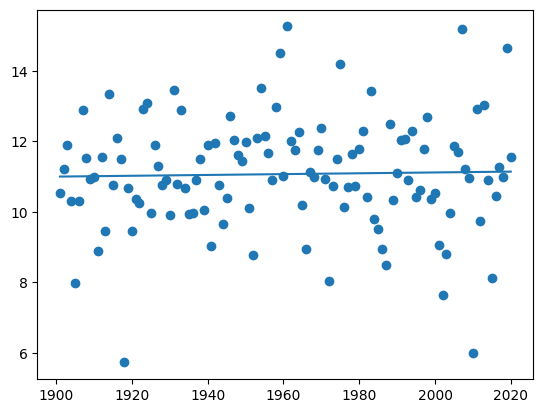

In [73]:
import numpy as np
import pandas as pd
da = pd.read_csv("precip_min.csv")
da

import numpy as np
import matplotlib.pyplot as plt

#define data
x = np.array(da.year)
y = np.array(da.RAINFALL)

#create scatterplot
plt.scatter(x, y)

#calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

In [75]:
z[0]

0.0011794159735078144

In [41]:
x=np.array(da.year); y=np.array(da.RAINFALL)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)


In [42]:
ax.text(1980, 4, 'Slope=0.43%/year*', style='italic', color='black', fontsize=20)


NameError: name 'ax' is not defined

In [43]:
x=np.array(da.year); y=np.array(da.RAINFALL)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

In [44]:
z[0]

-0.0021422408622032746

In [45]:
x

array([1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

In [46]:
a = Spatial_mean_India.RAINFALL
b = Spatial_mean_India.year

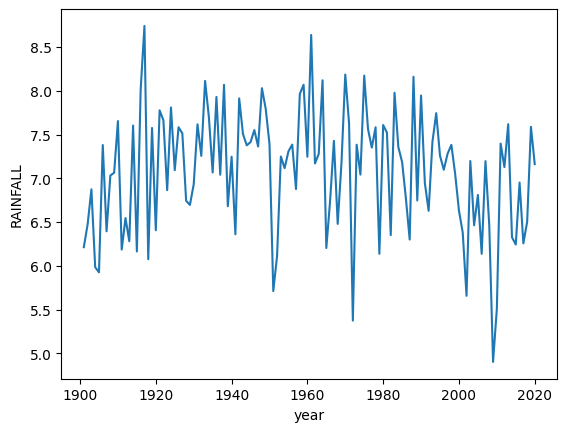

In [47]:
import matplotlib.pyplot as plt
a = Spatial_mean_India.RAINFALL.plot()

TypeError: unsupported operand type(s) for +: 'Line2D' and 'float'

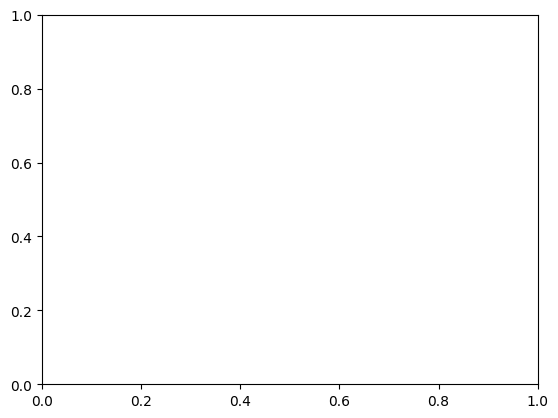

In [48]:

ax = plt.gca()

x=np.array(a); y=np.array(b)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(np.array(a),np.array(b), 'b-',linestyle='-', linewidth = 2, alpha=0.75)
ax.plot(x, p(x), 'b-')

In [49]:
year = precip_y.year
year

<xarray.DataArray 'year' (year: 120)>
array([1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912,
       1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)
Coordinates:
  * year     (year) int64 1901 1902 1903 1904 1905 ... 2016 2017 2018 2019 2020

In [50]:
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap

lat = precip_y.LATITUDE;
lon = precip_y.LONGITUDE

Regression_slope_precip=xr.DataArray(np.zeros((lat.shape[0], lon.shape[0])),coords=[lat, lon], dims=['lat','lon'])
Regression_pvalue_precip=xr.DataArray(np.zeros((lat.shape[0], lon.shape[0])),coords=[lat, lon], dims=['lat','lon'])
        
for i in range (0,lat.shape[0]):
    for j in range (0,lon.shape[0]):
        slope, intercept, r_value, p_value, std_err = stats.linregress(year, precip_y[:,i,j])
        Regression_slope_precip[i,j]=slope; Regression_pvalue_precip[i,j]=p_value
        del slope, intercept, r_value, p_value, std_err
    print ('lat done out of 31 is '+ str(i))
    
    
area2=np.full((lat.shape[0], lon.shape[0]), 1)
Regression_slope_precip=Regression_slope_precip.sortby('lat',ascending=True); Regression_pvalue_precip=Regression_pvalue_precip.sortby('lat',ascending=True)
dlons=Regression_slope_precip.lon; dlats=Regression_slope_precip.lat
area1 = np.ma.masked_where(Regression_pvalue_precip>=0.05, Regression_pvalue_precip)
area2=area2+area1
data=Regression_slope_precip
contours=np.arange(-0.01,0.01,0.001)
fig = plt.figure(figsize=(10,10), dpi=100)
m = Basemap(projection='mill',llcrnrlat=dlats[0], urcrnrlat=dlats[-1], llcrnrlon=dlons[0],urcrnrlon=dlons[-1], lat_ts=5, resolution='c')
m.drawparallels(np.arange(-20.,85.,5.),labels=[1,0,0,0],linewidth=0.05, fontsize=15)
m.drawmeridians(np.arange(60.,110.,10.),labels=[0,0,0,1],linewidth=0.05, fontsize=15)
m.readshapefile('/home/ganaraj/Documents/shapefile/Shapefile/States', 'States', linewidth=1.5)
flon,flat=np.meshgrid(dlons,dlats)
x,y=m(flon,flat)

cs1=m.scatter(x,y,s=area2*30,marker='D',color='teal', alpha=0.25)
cs=m.contourf(x,y,data,contours, cmap='RdBu_r', extend="both")
ca=plt.colorbar(ticks=[-1, 0.0, 1], shrink=0.8)
ca.ax.set_yticklabels(['-<1', '0.0', '>1'])
ca.ax.tick_params(labelsize=15)
cs1=m.scatter(x,y,s=area2*30,marker='D',color='teal', alpha=0.25)
plt.tight_layout()

ValueError: Unsupported key-type <class 'tuple'>

In [ ]:
import pymannkendall as mk

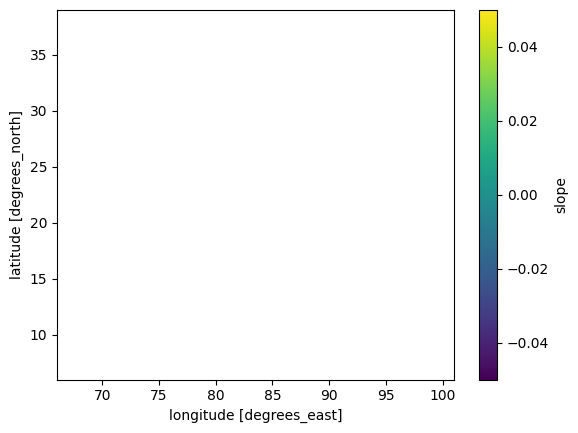

In [51]:
output=[]
for i  in precip_y.LATITUDE.values:
    for j in precip_y.LONGITUDE.values:
        
        try:
             slope_val=mk.original_test(precip_y.sel(LONGITUDE=j, LATITUDE=i)).slope
        except:
             slope_val=np.nan
        output.append(slope_val)
output=np.copy(output).reshape(precip_y.LATITUDE.size,precip_y.LONGITUDE.size)



slopes=xr.DataArray(output, dims=('LATITUDE','LONGITUDE'), coords=(precip_y.LATITUDE,precip_y.LONGITUDE), name='slope')
slopes.plot()


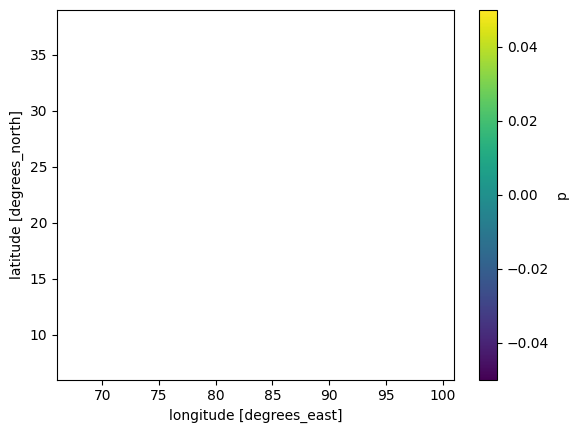

In [52]:
output=[]
for i  in precip_y.LATITUDE.values:
    for j in precip_y.LONGITUDE.values:
        
        try:
             p_val=mk.original_test(precip_y.sel(LONGITUDE=j, LATITUDE=i)).p
        except:
             p_val=np.nan
        output.append(p_val)
output=np.copy(output).reshape(precip_y.LATITUDE.size,precip_y.LONGITUDE.size)



p=xr.DataArray(output, dims=('LATITUDE','LONGITUDE'), coords=(precip_y.LATITUDE,precip_y.LONGITUDE), name='p')
p.plot()


ModuleNotFoundError: No module named 'regionmask'

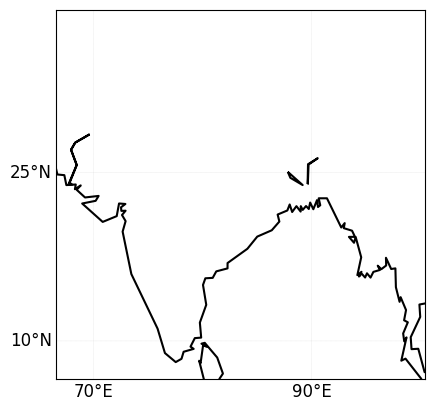

In [53]:
dlats=  slopes.LATITUDE
dlons=  slopes.LONGITUDE
m = Basemap(projection='mill',llcrnrlat=dlats[0], urcrnrlat=dlats[-1], llcrnrlon=dlons[0],urcrnrlon=dlons[-1], lat_ts=5, resolution='c')
m.drawparallels(np.arange(-20.,45.,15.),labels=[1,0,0,0],linewidth=0.05, fontsize=12)
m.drawmeridians(np.arange(30.,120.,20.),labels=[0,0,0,1],linewidth=0.05, fontsize=12)
m.drawcoastlines(linewidth=1.5, linestyle='solid', color='k' ) 
flon,flat=np.meshgrid(dlons,dlats)
x,y=m(flon,flat)
contour=np.arange(-0.005,0.005,0.0005)
import regionmask


cs=m.contourf(x,y,slopes,contour, cmap='RdBu_r', extend="both")

plt.colorbar()

lat=p.LATITUDE; lon=p.LONGITUDE
area2=np.full((lat.shape[0], lon.shape[0]), 1)
area1 = np.ma.masked_where(p >=0.05, p)
area2=area2+area1
cs1=m.scatter(x,y,s=area2*5,marker='D',color='teal', alpha=0.25)

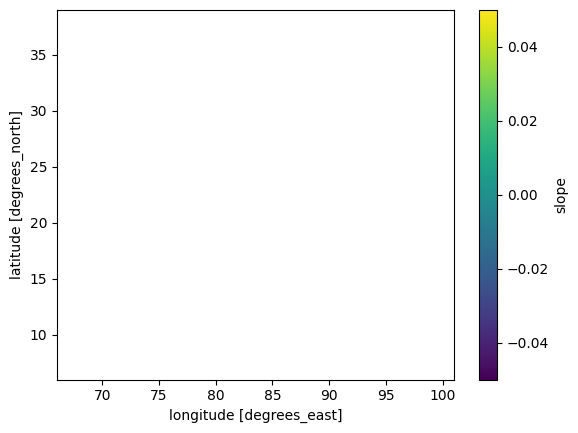

In [54]:
output=[]
for i  in precip_y.LATITUDE.values:
    for j in precip_y.LONGITUDE.values:
        
        try:
             slope_val=mk.sens_slope(precip_y.sel(LONGITUDE=j, LATITUDE=i)).slope
        except:
             slope_val=np.nan
        output.append(slope_val)
output=np.copy(output).reshape(precip_y.LATITUDE.size,precip_y.LONGITUDE.size)



slopes=xr.DataArray(output, dims=('LATITUDE','LONGITUDE'), coords=(precip_y.LATITUDE,precip_y.LONGITUDE), name='slope')
slopes.plot()


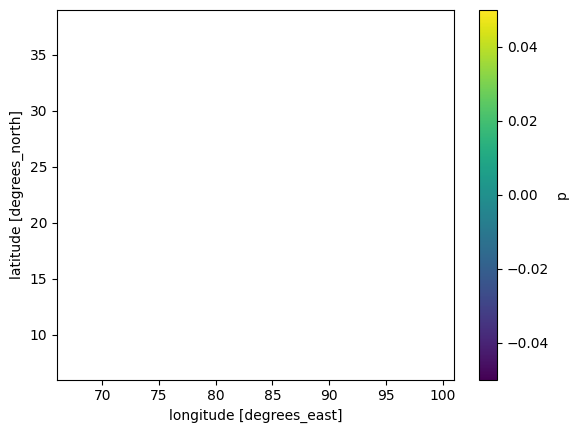

In [55]:
output=[]
for i  in precip_y.LATITUDE.values:
    for j in precip_y.LONGITUDE.values:
        
        try:
             p_val=mk.sens_slope(precip_y.sel(LONGITUDE=j, LATITUDE=i)).p
        except:
             p_val=np.nan
        output.append(p_val)
output=np.copy(output).reshape(precip_y.LATITUDE.size,precip_y.LONGITUDE.size)



p=xr.DataArray(output, dims=('LATITUDE','LONGITUDE'), coords=(precip_y.LATITUDE,precip_y.LONGITUDE), name='p')
p.plot()


In [56]:

cloud_cover_Ind = cloud_cover.where(
    (cloud_cover.lat < 43 ) & (cloud_cover.lat > -6) & (cloud_cover.lon > 38) & (cloud_cover.lon < 122), drop=True
)
cloud_cover_Ind

NameError: name 'cloud_cover' is not defined